#DDPG (Deep Deterministic Policy Gradient)



- 2 networks used:
  - Actor π(s): models a policy that maps state to action
  - Critic Q(s,a): estimate the expected reward for the agent taking action at a particular state 
- Trained using Value function. 
```
V (st) = r(st, at) + γV (st+1)
```
Here r(st,at) is the reward when performing action at based on st i.e. WGAN.


---





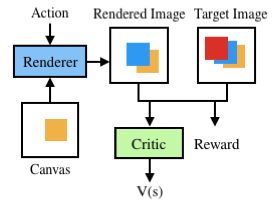

Target image : I, empty canvas C0, stroke sequence/action sequence: (a0, a1, ….,
an)

Agent should aim to create the stroke sequence where rendering at on Ctgives Ct+1

Model this task as Markov Decision Process (MDP) with state space: S, action space: A, transition function: trans(st, at), reward function: r(st, at) 
State: st = (Ct, I, t) -> state of canvas, Target Image, step number(so the agent knows how many steps are still left)

transition function: trans(st, at) is transition between states which is implemented by painting a stroke on canvas
Action at is a set of parameters to ctrl position, shape, color and transparency of stroke at step t

behavior of agent = policy function π → map states to actions = π : S → A

Reward: r(st, at)=Lt − Lt+1  Lt  is  loss between target image I and canvas Ct at step t

 Objective of agent: maximize sum of discounted future reward 


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from Renderer.model import *
from DRL.rpm import rpm
from DRL.actor import *
from DRL.critic import *
from DRL.wgan import *
from utils.util import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
coord = torch.zeros([1, 2, 128, 128])
for i in range(128):
    for j in range(128):
        coord[0, 0, i, j] = i / 127.
        coord[0, 1, i, j] = j / 127.
coord = coord.to(device)

criterion = nn.MSELoss()

Decoder = FCN()
Decoder.load_state_dict(torch.load('../renderer.pkl'))


###Decode Canvas

In [ ]:
def decode(x, canvas): # b * (10 + 3)
    x = x.view(-1, 10 + 3)
    stroke = 1 - Decoder(x[:, :10])
    stroke = stroke.view(-1, 128, 128, 1)
    color_stroke = stroke * x[:, -3:].view(-1, 1, 1, 3)
    stroke = stroke.permute(0, 3, 1, 2)
    color_stroke = color_stroke.permute(0, 3, 1, 2)
    stroke = stroke.view(-1, 5, 1, 128, 128)
    color_stroke = color_stroke.view(-1, 5, 3, 128, 128)
    for i in range(5):
        canvas = canvas * (1 - stroke[:, i]) + color_stroke[:, i]
    return canvas

In [ ]:
def cal_trans(s, t):
    return (s.transpose(0, 3) * t).transpose(0, 3)

In [ ]:
class DDPG(object):
    def __init__(self, batch_size=64, env_batch=1, max_step=40, \
                 tau=0.001, discount=0.9, rmsize=800, \
                 writer=None, resume=None, output_path=None):

        self.max_step = max_step
        self.env_batch = env_batch
        self.batch_size = batch_size        

        self.actor = ResNet(9, 18, 65) # target, canvas, stepnum, coordconv 3 + 3 + 1 + 2
        self.actor_target = ResNet(9, 18, 65)
        self.critic = ResNet_wobn(3 + 9, 18, 1) # add the last canvas for better prediction
        self.critic_target = ResNet_wobn(3 + 9, 18, 1) 

        self.actor_optim  = Adam(self.actor.parameters(), lr=1e-2)
        self.critic_optim  = Adam(self.critic.parameters(), lr=1e-2)

        if (resume != None):
            self.load_weights(resume)

        hard_update(self.actor_target, self.actor)
        hard_update(self.critic_target, self.critic)
        
        # Create replay buffer
        self.memory = rpm(rmsize * max_step)

        # Hyper-parameters
        self.tau = tau
        self.discount = discount

        # Tensorboard
        self.writer = writer
        self.log = 0
        
        self.state = [None] * self.env_batch # Most recent state
        self.action = [None] * self.env_batch # Most recent action
        self.choose_device()        

    def play(self, state, target=False):
        state = torch.cat((state[:, :6].float() / 255, state[:, 6:7].float() / self.max_step, coord.expand(state.shape[0], 2, 128, 128)), 1)
        if target:
            return self.actor_target(state)
        else:
            return self.actor(state)

    def update_gan(self, state):
        canvas = state[:, :3]
        gt = state[:, 3 : 6]
        fake, real, penal = update(canvas.float() / 255, gt.float() / 255)
        if self.log % 20 == 0:
            self.writer.add_scalar('train/gan_fake', fake, self.log)
            self.writer.add_scalar('train/gan_real', real, self.log)
            self.writer.add_scalar('train/gan_penal', penal, self.log)       
        
    def evaluate(self, state, action, target=False):
        T = state[:, 6 : 7]
        gt = state[:, 3 : 6].float() / 255
        canvas0 = state[:, :3].float() / 255
        canvas1 = decode(action, canvas0)
        gan_reward = cal_reward(canvas1, gt) - cal_reward(canvas0, gt)
        # L2_reward = ((canvas0 - gt) ** 2).mean(1).mean(1).mean(1) - ((canvas1 - gt) ** 2).mean(1).mean(1).mean(1)        
        coord_ = coord.expand(state.shape[0], 2, 128, 128)
        merged_state = torch.cat([canvas0, canvas1, gt, (T + 1).float() / self.max_step, coord_], 1)
        # canvas0 is not necessarily added
        if target:
            Q = self.critic_target(merged_state)
            return (Q + gan_reward), gan_reward
        else:
            Q = self.critic(merged_state)
            if self.log % 20 == 0:
                self.writer.add_scalar('train/expect_reward', Q.mean(), self.log)
                self.writer.add_scalar('train/gan_reward', gan_reward.mean(), self.log)
            return (Q + gan_reward), gan_reward
    
    def update_policy(self, lr):
        self.log += 1
        
        for param_group in self.critic_optim.param_groups:
            param_group['lr'] = lr[0]
        for param_group in self.actor_optim.param_groups:
            param_group['lr'] = lr[1]
            
        # Sample batch
        state, action, reward, \
            next_state, terminal = self.memory.sample_batch(self.batch_size, device)

        self.update_gan(next_state)
        
        with torch.no_grad():
            next_action = self.play(next_state, True)
            target_q, _ = self.evaluate(next_state, next_action, True)
            target_q = self.discount * ((1 - terminal.float()).view(-1, 1)) * target_q
                
        cur_q, step_reward = self.evaluate(state, action)
        target_q += step_reward.detach()
        
        value_loss = criterion(cur_q, target_q)
        self.critic.zero_grad()
        value_loss.backward(retain_graph=True)
        self.critic_optim.step()

        action = self.play(state)
        pre_q, _ = self.evaluate(state.detach(), action)
        policy_loss = -pre_q.mean()
        self.actor.zero_grad()
        policy_loss.backward(retain_graph=True)
        self.actor_optim.step()
        
        # Target update
        soft_update(self.actor_target, self.actor, self.tau)
        soft_update(self.critic_target, self.critic, self.tau)

        return -policy_loss, value_loss

    def observe(self, reward, state, done, step):
        s0 = torch.tensor(self.state, device='cpu')
        a = to_tensor(self.action, "cpu")
        r = to_tensor(reward, "cpu")
        s1 = torch.tensor(state, device='cpu')
        d = to_tensor(done.astype('float32'), "cpu")
        for i in range(self.env_batch):
            self.memory.append([s0[i], a[i], r[i], s1[i], d[i]])
        self.state = state

    def noise_action(self, noise_factor, state, action):
        noise = np.zeros(action.shape)
        for i in range(self.env_batch):
            action[i] = action[i] + np.random.normal(0, self.noise_level[i], action.shape[1:]).astype('float32')
        return np.clip(action.astype('float32'), 0, 1)
    
    def select_action(self, state, return_fix=False, noise_factor=0):
        self.eval()
        with torch.no_grad():
            action = self.play(state)
            action = to_numpy(action)
        if noise_factor > 0:        
            action = self.noise_action(noise_factor, state, action)
        self.train()
        self.action = action
        if return_fix:
            return action
        return self.action

    def reset(self, obs, factor):
        self.state = obs
        self.noise_level = np.random.uniform(0, factor, self.env_batch)

    def load_weights(self, path):
        if path is None: return
        self.actor.load_state_dict(torch.load('{}/actor.pkl'.format(path)))
        self.critic.load_state_dict(torch.load('{}/critic.pkl'.format(path)))
        load_gan(path)
        
    def save_model(self, path):
        self.actor.cpu()
        self.critic.cpu()
        torch.save(self.actor.state_dict(),'{}/actor.pkl'.format(path))
        torch.save(self.critic.state_dict(),'{}/critic.pkl'.format(path))
        save_gan(path)
        self.choose_device()

    def eval(self):
        self.actor.eval()
        self.actor_target.eval()
        self.critic.eval()
        self.critic_target.eval()
    
    def train(self):
        self.actor.train()
        self.actor_target.train()
        self.critic.train()
        self.critic_target.train()
    
    def choose_device(self):
        Decoder.to(device)
        self.actor.to(device)
        self.actor_target.to(device)
        self.critic.to(device)
        self.critic_target.to(device)